In [1]:
import backtrader as bt
import pandas as pd
import calendar
from datetime import datetime
import empyrical as ep
import pyfolio as pf
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# 定義期貨到期日函數
def option_expiration(date):
    # 計算當月的期權到期日
    day = 21 - (calendar.weekday(date.year, date.month, 1) + 4) % 7
    return datetime(date.year, date.month, day)

In [10]:
# 定義回測策略
class SampleStrategy(bt.Strategy):
    def log(self, txt, dt=None, is_stock=True):
        # 根據是否為股票或期貨選擇不同的 datetime
        if is_stock:
            dt = dt or self.datas[0].datetime.datetime(0) # 使用 0050 的 datetime
        else:
            dt = dt or self.datas[1].datetime.datetime(0) # 使用 TXF 的 datetime
        print(('%s, %s' % (dt.isoformat(), txt)))

    def __init__(self):
        self.dataclose_0050 = self.datas[0].close
        self.dataclose_txf = self.datas[1].close
        self.order_0050 = None
        self.order_txf = None
        self.first_trade_done = False
        self.cash_reserved_for_txf = 1000000  # 預留給期貨的現金

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            is_stock = order.data._name == '0050'
            if order.isbuy():
                self.log(f"""買入執行{order.data._name},
                         價格: {order.executed.price:.2f},
                         成本: {order.executed.value:.2f},
                         手續費: {order.executed.comm:.2f}""",
                         is_stock=is_stock)
            else:
                self.log(f"""賣出執行{order.data._name},
                         價格: {order.executed.price:.2f},
                         成本: {order.executed.value:.2f},
                         手續費: {order.executed.comm:.2f}""", is_stock=is_stock)
            self.order_0050 = None
            self.order_txf = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return 
        
        is_stock = trade.data._name == '0050'
        self.log(f"操作利潤 {trade.data._name}, 淨利 {trade.pnl:.2f}", is_stock=is_stock)

    def next(self):
        status = None
        position_size = self.getposition(data=self.datas[1]).size
        futures_date = self.datas[1].datetime.datetime(0)

        if (
            option_expiration(futures_date).day
            == futures_date.day
        ):
            if futures_date.hour >= 13:
                status = "end"
                if position_size != 0:
                    self.close(data=self.datas[1])
                    self.log("因到期日平倉 TXF 持倉", is_stock=False)

        if not self.first_trade_done:
            # 做多 0050 除了期貨的部分，並做空(sell) 1 口 TXF
            available_cash_for_0050 = self.broker.getcash() - self.cash_reserved_for_txf
            size_0050 = int(available_cash_for_0050 / self.dataclose_0050[0])
            self.order_0050 = self.buy(data=self.datas[0], size=size_0050)
            self.log(f"創建 0050 買入訂單, 大小: {size_0050}", is_stock=True)
            self.order_txf = self.sell(data=self.datas[1], size=1)
            self.log(f"創建 TXF 賣出訂單", is_stock=False)
            self.first_trade_done = True
        else:
            if status != "end" and self.first_trade_done and position_size == 0:
                self.order_txf = self.sell(data=self.datas[1], size=1)
                self.log("創建 TXF 賣出訂單", is_stock=False)
                self.first_trade_done = True






In [11]:
# 初始化 Cerebro 引擎
cerebro = bt.Cerebro()
# 使用 yfinance 加載 0050 的日 K 資料
data_0050 = yf.download("0050.TW", start="2019-03-04", end="2020-02-28").droplevel(
    "Ticker", axis=1
)
data_0050 = data_0050[["Open", "High", "Low", "Close", "Volume"]]
data_0050 = data_0050.reset_index()
data_0050["Date"] = pd.to_datetime(data_0050["Date"])

# 準備 0050 數據 feed
data_feed_0050 = bt.feeds.PandasData(
    dataname=data_0050,
    name="0050",
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    plot=False,
)
cerebro.adddata(data_feed_0050, name="0050")
cerebro.broker.setcommission(commission=0.001, name="0050")  # 設定 0050 手續費為 0.1%

# 加載 TXF 的 30 分鐘 K 線資料
df = pd.read_csv("TXF_30.csv")
df = df.dropna()  # 確保沒有缺失值
df["Date"] = pd.to_datetime(df["Date"])
df.index = df["Date"]
df = df.between_time("08:45", "13:45")

# 準備 TXF 數據 feed
data_feed_txf = bt.feeds.PandasData(
    dataname=df,
    name="TXF",
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    plot=False,
)

cerebro.adddata(data_feed_txf, name="TXF")
# 設定初始現金及手續費信息
cerebro.broker.setcash(5000000)
cerebro.broker.setcommission(commission=200, margin=16700, mult=200, name="TXF")

# 添加策略至 cerebro
cerebro.addstrategy(SampleStrategy)
# 輸出初始組合資產價值
print("初始組合資產價值: %.2f" % cerebro.broker.getvalue())

# 添加 PyFolio 分析器
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# 執行回測
results = cerebro.run()



[*********************100%***********************]  1 of 1 completed


初始組合資產價值: 5000000.00
2019-03-04T00:00:00, 創建 0050 買入訂單, 大小: 253162
2019-03-04T09:15:00, 創建 TXF 賣出訂單
2019-03-04T09:45:00, 賣出執行TXF,
                         價格: 10309.00,
                         成本: 16700.00,
                         手續費: 200.00
2019-03-05T00:00:00, 買入執行0050,
                         價格: 15.73,
                         成本: 3981792.01,
                         手續費: 3981.79
2019-03-20T13:15:00, 因到期日平倉 TXF 持倉
2019-03-20T13:45:00, 買入執行TXF,
                         價格: 10543.00,
                         成本: 16700.00,
                         手續費: 200.00
2019-03-20T13:45:00, 操作利潤 TXF, 淨利 -46800.00
2019-03-21T09:15:00, 創建 TXF 賣出訂單
2019-03-21T09:45:00, 賣出執行TXF,
                         價格: 10550.00,
                         成本: 16700.00,
                         手續費: 200.00
2019-04-17T13:15:00, 因到期日平倉 TXF 持倉
2019-04-17T13:45:00, 買入執行TXF,
                         價格: 11004.00,
                         成本: 16700.00,
                         手續費: 200.00
2019-04-17T13:45:00, 操作利潤 T

In [12]:
# 輸出最終組合資產價值
print(f"最終組合資產價值: {cerebro.broker.getvalue():.2f}")


最終組合資產價值: 5484145.78


In [17]:
# 使用 PyFolio 分析結果
strat = results[0]
pyfoliozer = strat.analyzers.getbyname("pyfolio")
returns, positions, transactinos, gross_lev = pyfoliozer.get_pf_items()

Start date,2019-03-05
End date,2020-02-27
Total months,11
,Backtest
Annual return,10.311%
Cumulative returns,9.797%
Annual volatility,6.777%
Sharpe ratio,1.48
Calmar ratio,2.42
Stability,0.81
Max drawdown,-4.256%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.26,2019-05-03,2019-05-29,2019-07-25,60
1,3.42,2020-01-14,2020-02-27,NaT,NaN
2,2.43,2019-07-25,2019-08-15,2019-09-10,34
3,1.77,2019-11-19,2019-11-29,2019-12-12,18
4,1.33,2019-12-17,2020-01-08,2020-01-14,21


Stress Events,mean,min,max
Covid,-0.09%,-0.75%,0.60%


Top 10 long positions of all time,max
TXF,3.28%


Top 10 short positions of all time,max


Top 10 positions of all time,max
TXF,3.28%


累積回報: 0.09682915696402539
最大回撤: -0.04256023591953016
夏普比率: 1.4595915331835743


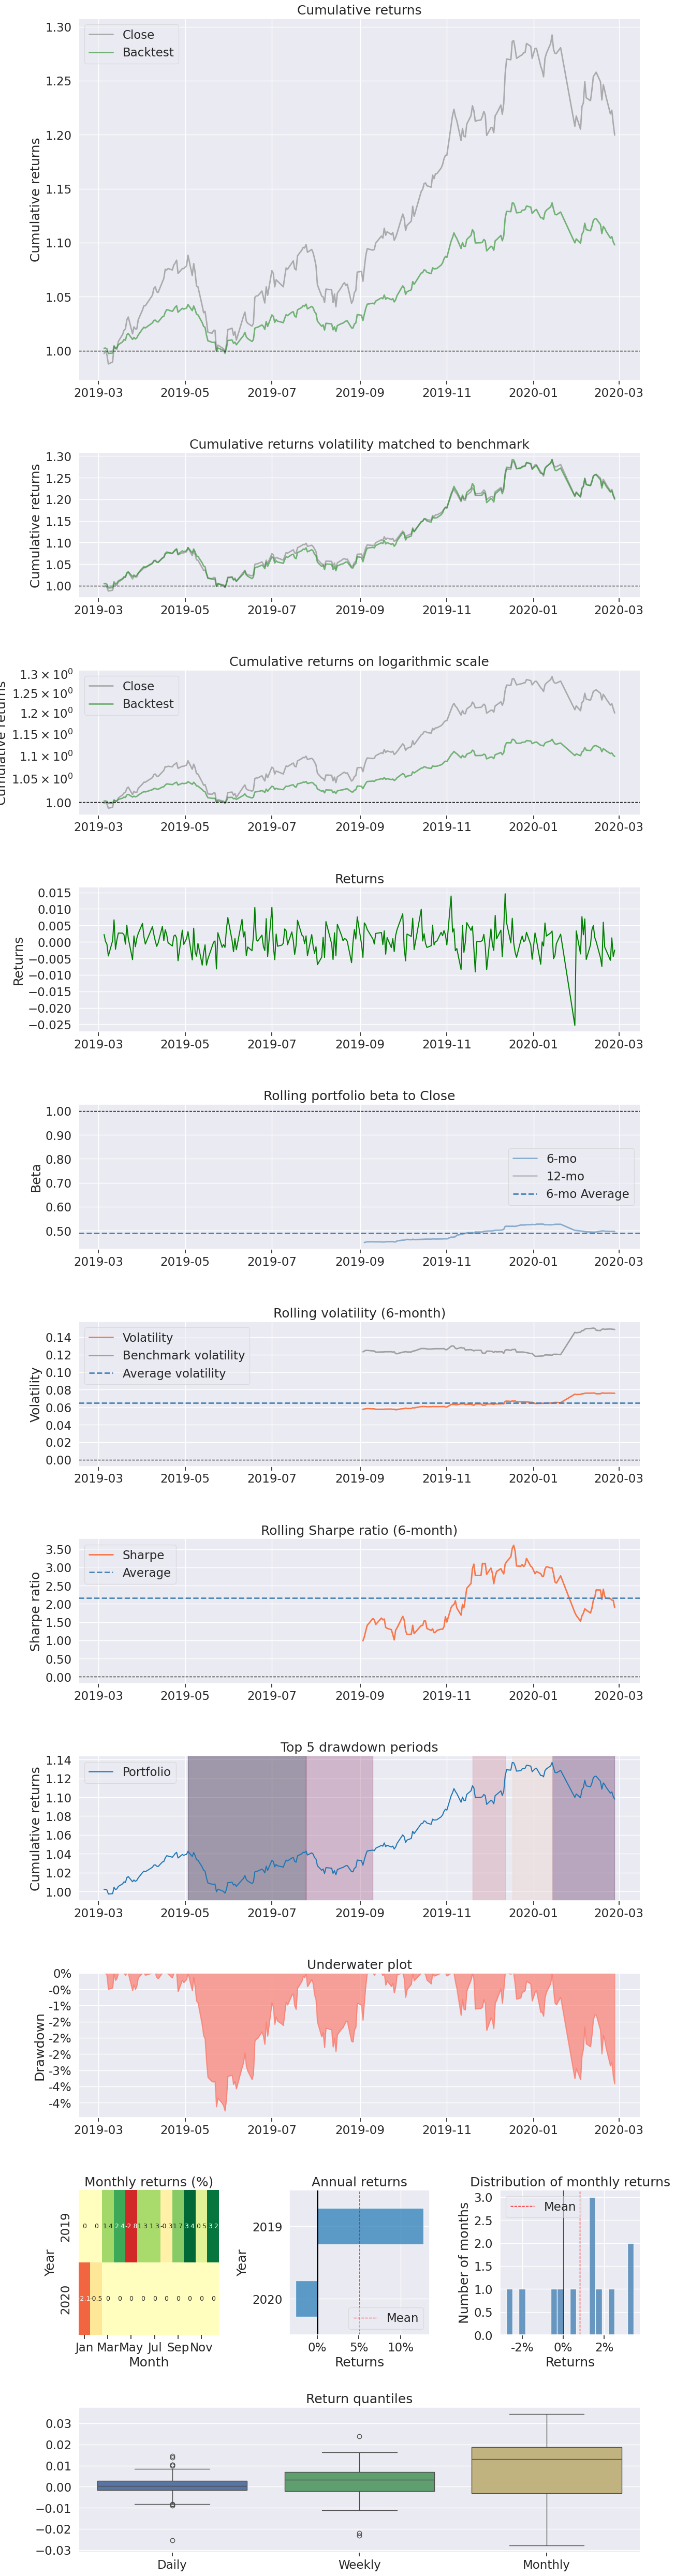

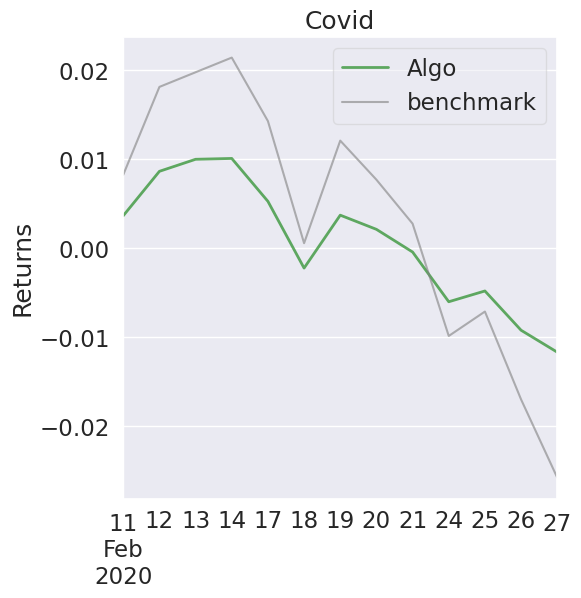

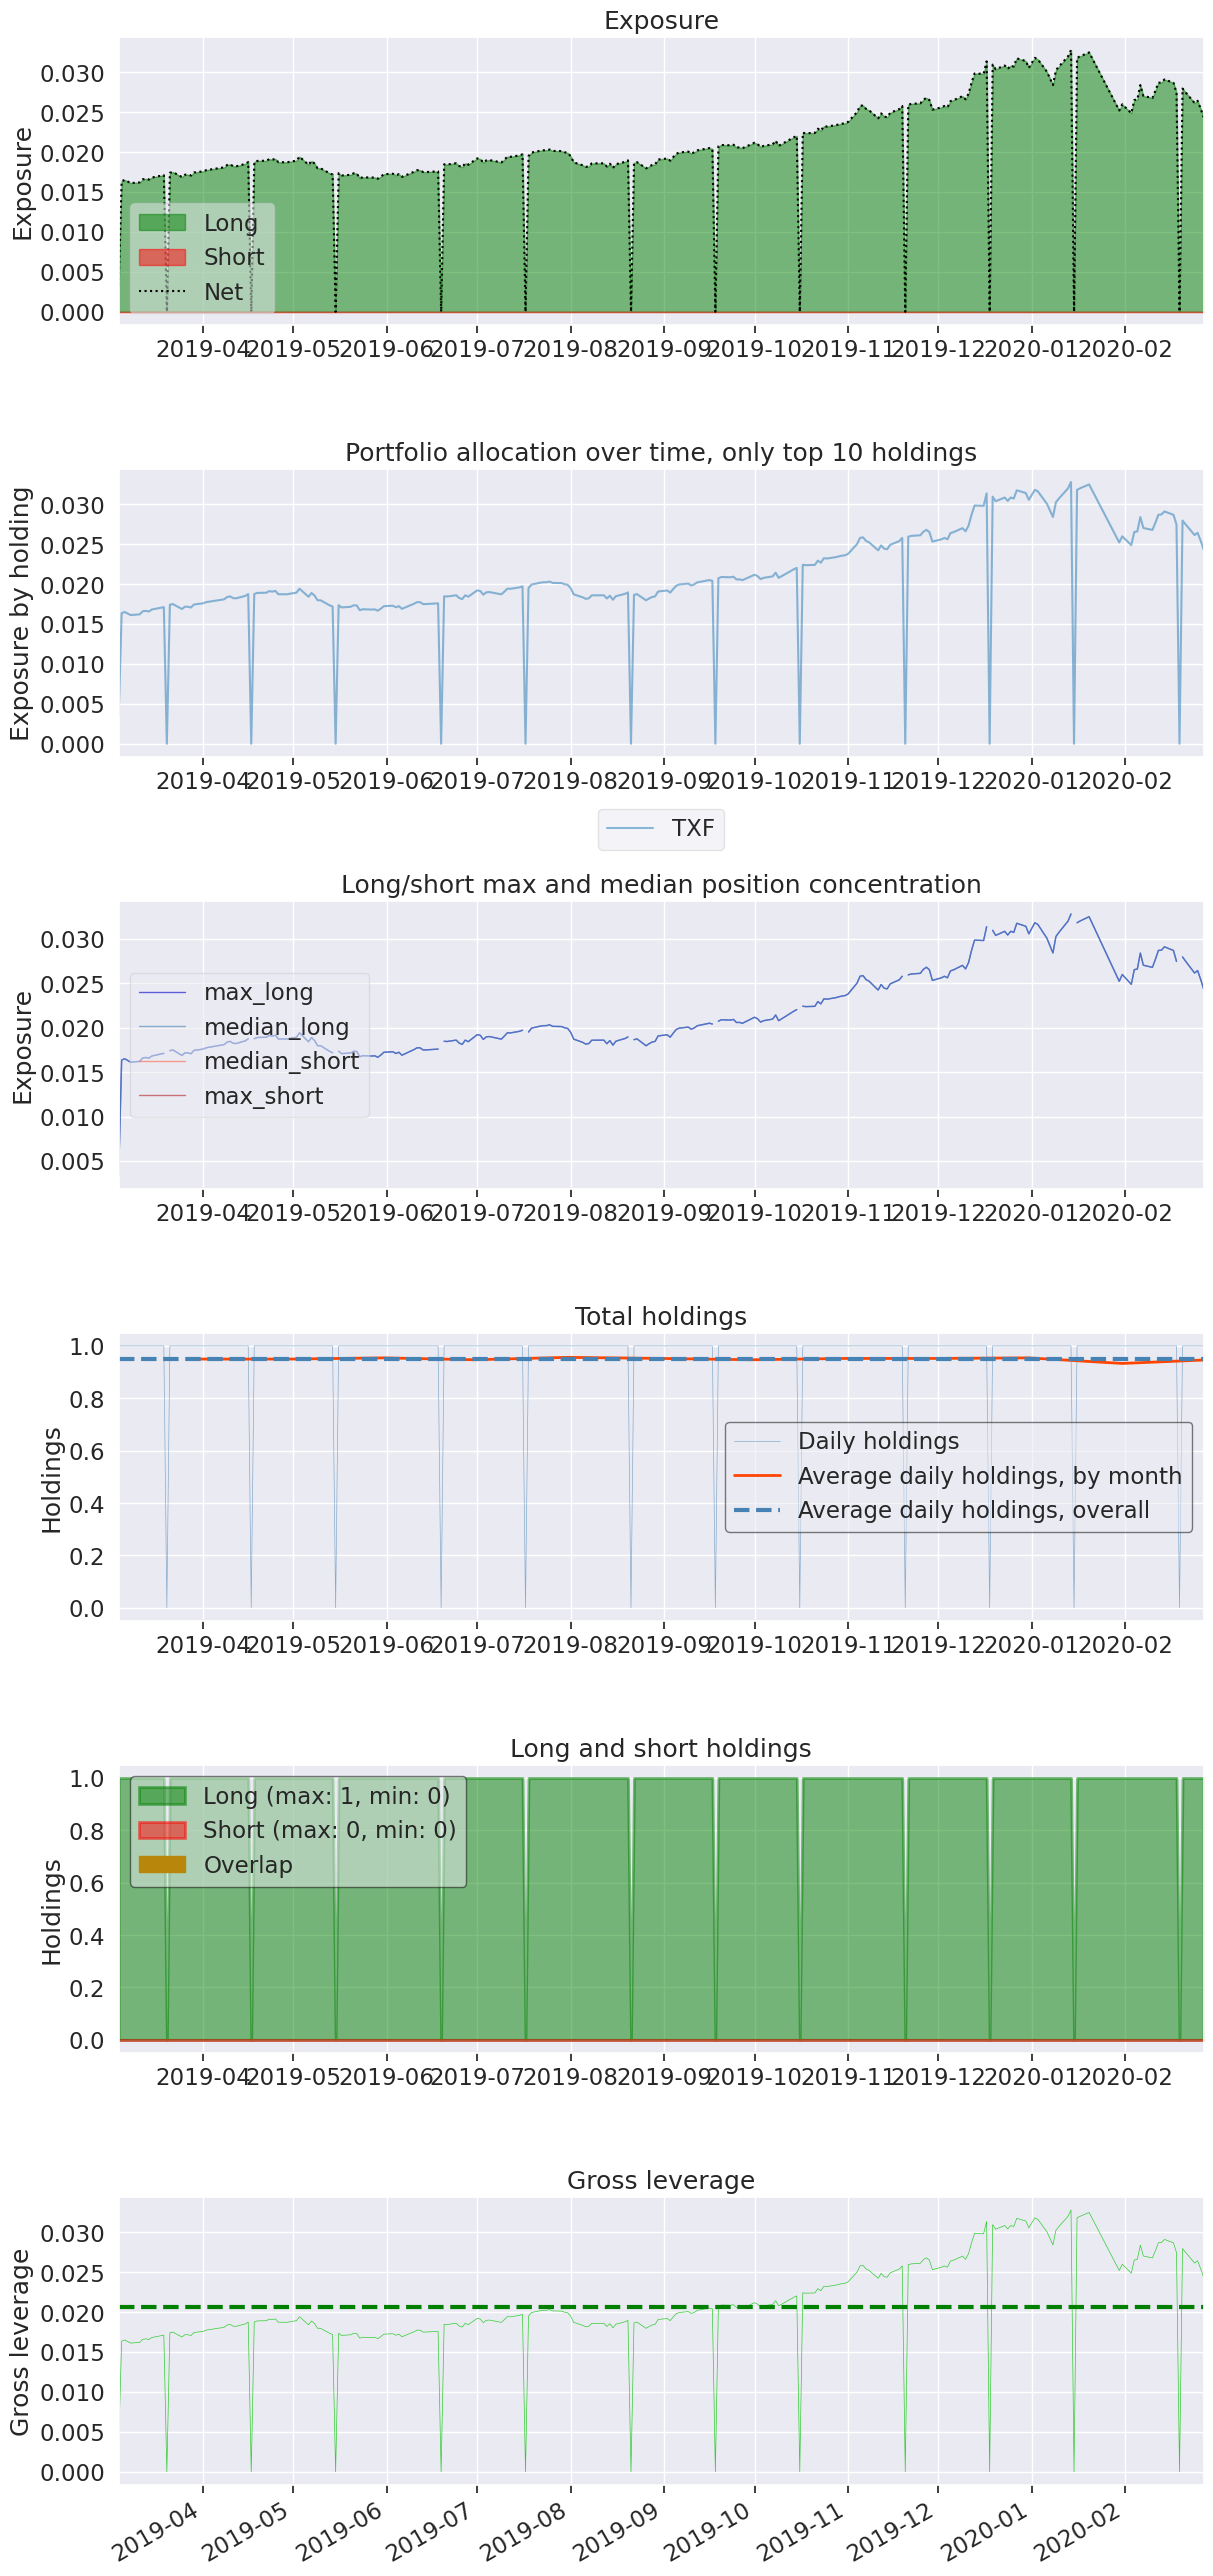

In [22]:
# 加入 benchmark (0050 的收盤價作為基準)
benchmark_returns = data_0050.set_index('Date')['Close'].pct_change().dropna()
benchmark_returns.index = pd.to_datetime(benchmark_returns.index).tz_localize('UTC')
pf.create_full_tear_sheet(returns, benchmark_rets=benchmark_returns, positions=positions)

print(f"累積回報: {ep.cum_returns_final(returns)}")
print(f"最大回撤: {ep.max_drawdown(returns)}")
print(f"夏普比率: {ep.sharpe_ratio(returns)}")

In [20]:
data_0050

Price,Date,Open,High,Low,Close,Volume
0,2019-03-04,15.923301,15.923301,15.748770,15.800102,33878280
1,2019-03-05,15.728237,15.789837,15.697438,15.759037,37601972
2,2019-03-06,15.779570,15.820636,15.759037,15.800102,78319168
3,2019-03-07,15.789836,15.820636,15.728236,15.738503,72959080
4,2019-03-08,15.646104,15.676904,15.563973,15.605039,39900800
...,...,...,...,...,...,...
236,2020-02-21,19.595779,19.659921,19.446110,19.510254,21604752
237,2020-02-24,19.296442,19.328514,19.178845,19.264370,54287744
238,2020-02-25,19.136082,19.349893,19.125391,19.317822,35360416
239,2020-02-26,19.061249,19.189535,19.007796,19.125391,60324012
